<a href="https://www.kaggle.com/code/mohanadmoustafa/brain-tumor-segmentatio?scriptVersionId=263616342" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import PIL 
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

2025-09-23 20:06:22.668305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758657982.866680      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758657982.926170      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Reading Data

In [2]:
root = '/kaggle/input/brain-tumor-segmentation'

In [3]:
folders = os.listdir(root)
folders

['images', 'masks']

In [4]:
img_files = sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/images'))
mask_files = sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/masks'))

In [5]:
print("images_len: ", len(img_files))
print("masks_len: ", len(mask_files))

images_len:  3064
masks_len:  3064


In [6]:
print(img_files[:10])
print(mask_files[:10])

['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']
['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']


In [7]:
imgs_path = '/kaggle/input/brain-tumor-segmentation/images'
masks_path = '/kaggle/input/brain-tumor-segmentation/masks'

H = 256
W = 256
C = 1

Class_num = 1

## Data Preprcessing

In [8]:
def preprocessing_data():
    images = []
    masks = []
    for img_file, mask_file in tqdm(zip(img_files, mask_files)):
        img_path_full = os.path.join(imgs_path, img_file)
        mask_path_full = os.path.join(masks_path, mask_file)
        img = cv2.imread(img_path_full, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path_full, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (H, W))
        mask = cv2.resize(mask, (H, W))
        img = img/255.0
        mask = mask/255.0
        images.append(img)
        masks.append(mask)
    images = np.expand_dims(np.array(images), axis = -1)
    masks = np.expand_dims(np.array(masks), axis= -1)

    return images, masks


In [9]:
X, y = preprocessing_data()

3064it [01:11, 42.62it/s]


In [10]:
print('The Shape of X',X.shape)
print('The Shape of y',y.shape)

The Shape of X (3064, 256, 256, 1)
The Shape of y (3064, 256, 256, 1)


## Splitting the Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

The shape of X_train (2451, 256, 256, 1)
The shape of y_train (2451, 256, 256, 1)
The shape of X_test (613, 256, 256, 1)
The shape of y_test (613, 256, 256, 1)


In [13]:
from keras.models import Model
from keras.layers import *

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint ,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

## Build U-Net Model

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Dropout, Concatenate

def build_UNet(input_size=(H, W, C)):
    inputs = Input(input_size)

    # Encoder
    e1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    e1 = BatchNormalization()(e1)
    e1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(e1)
    e1 = BatchNormalization()(e1)
    p1 = MaxPooling2D((2, 2))(e1)

    e2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    e2 = BatchNormalization()(e2)
    e2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(e2)
    e2 = BatchNormalization()(e2)
    p2 = MaxPooling2D((2, 2))(e2)

    e3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    e3 = BatchNormalization()(e3)
    e3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(e3)
    e3 = BatchNormalization()(e3)
    p3 = MaxPooling2D((2, 2))(e3)

    e4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    e4 = BatchNormalization()(e4)
    e4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(e4)
    e4 = BatchNormalization()(e4)
    p4 = MaxPooling2D((2, 2))(e4)

    e5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    e5 = BatchNormalization()(e5)
    e5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(e5)
    e5 = BatchNormalization()(e5)
    p5 = MaxPooling2D((2, 2))(e5)

    # Bottleneck
    b1 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p5)
    b1 = BatchNormalization()(b1)
    b1 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(b1)
    b1 = BatchNormalization()(b1)
    b1 = Dropout(0.3)(b1)  # Dropout in bottleneck

    # Decoder
    d1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(b1)
    d1 = Concatenate()([d1, e5])
    d1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(d1)
    d1 = BatchNormalization()(d1)

    d2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(d1)
    d2 = Concatenate()([d2, e4])
    d2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d2 = BatchNormalization()(d2)

    d3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d3 = Concatenate()([d3, e3])
    d3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d3 = BatchNormalization()(d3)

    d4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d4 = Concatenate()([d4, e2])
    d4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    d4 = BatchNormalization()(d4)

    d5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    d5 = Concatenate()([d5, e1])
    d5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(d5)
    d5 = BatchNormalization()(d5)
    d5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(d5)
    d5 = BatchNormalization()(d5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d5)

    model = Model(inputs, outputs)
    return model


In [15]:
model = build_UNet(input_size=(H, W,C))
model.summary()

I0000 00:00:1758658069.640150      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758658069.640923      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[

 Total params: 31,117,985 (118.71 MB)

 Trainable params: 31,105,953 (118.66 MB)

 Non-trainable params: 12,032 (47.00 KB)

In [16]:
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [17]:
model.compile(optimizer=Adam(learning_rate=0.005), loss=dice_loss, metrics=[dice_coefficient, iou_metric])

In [18]:
earlystopping = EarlyStopping(
    patience=5, 
    monitor='val_dice_coefficient', 
    mode='max', 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_dice_coefficient', 
    mode='max',
    factor=0.1, 
    patience=10, 
    min_lr=1e-7
)


## Model Training

In [19]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[earlystopping, reduce_lr]
)


Epoch 1/50


I0000 00:00:1758658096.698343      62 service.cc:148] XLA service 0x7df190002270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758658096.699417      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758658096.699437      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758658098.781224      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-23 20:09:12.323357: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[32,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_qu

76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - dice_coefficient: 0.1446 - iou_metric: 0.0806 - loss: 0.8554

E0000 00:00:1758658233.383066      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758658233.623391      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-23 20:10:55.286145: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,64,256,256]{3,2,1,0}, f32[19,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-09-23 20:10:55.606

77/77 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - dice_coefficient: 0.1470 - iou_metric: 0.0822 - loss: 0.8530 - val_dice_coefficient: 0.0328 - val_iou_metric: 0.0167 - val_loss: 0.9681 - learning_rate: 0.0050
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 58s 754ms/step - dice_coefficient: 0.3955 - iou_metric: 0.2494 - loss: 0.6045 - val_dice_coefficient: 0.0759 - val_iou_metric: 0.0395 - val_loss: 0.9246 - learning_rate: 0.0050
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 57s 745ms/step - dice_coefficient: 0.4619 - iou_metric: 0.3030 - loss: 0.5381 - val_dice_coefficient: 0.0422 - val_iou_metric: 0.0216 - val_loss: 0.9591 - learning_rate: 0.0050
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 57s 744ms/step - dice_coefficient: 0.5536 - iou_metric: 0.3849 - loss: 0.4464 - val_dice_coefficient: 0.0739 - val_iou_metric: 0.0384 - val_loss: 0.9282 - learning_rate: 0.0050
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 57s 742ms/step - dice_coefficient: 0.5271 - iou_metric: 0.3603 - loss: 0.4729 - val_dice_coefficient: 0.0687 - val_

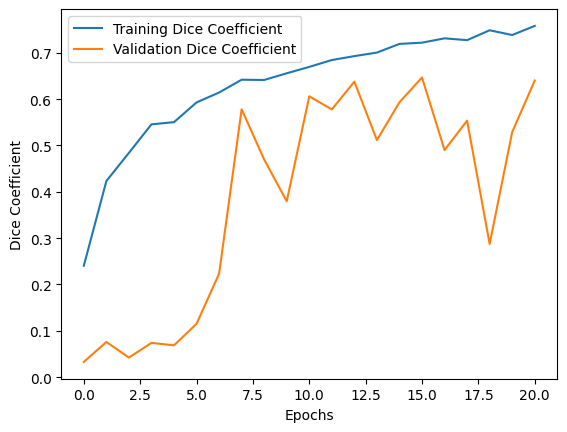

In [20]:
plt.plot(history.history['dice_coefficient'], label = 'Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label = 'Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

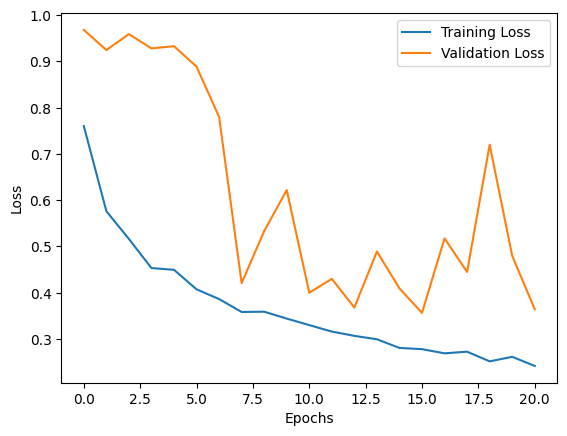

In [21]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
y_pred = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 311ms/step


In [23]:
y_pred = (y_pred > 0.5).astype(np.uint8)

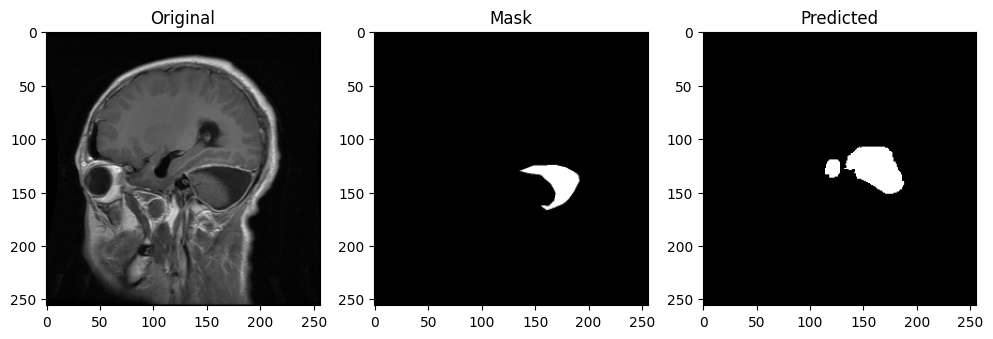

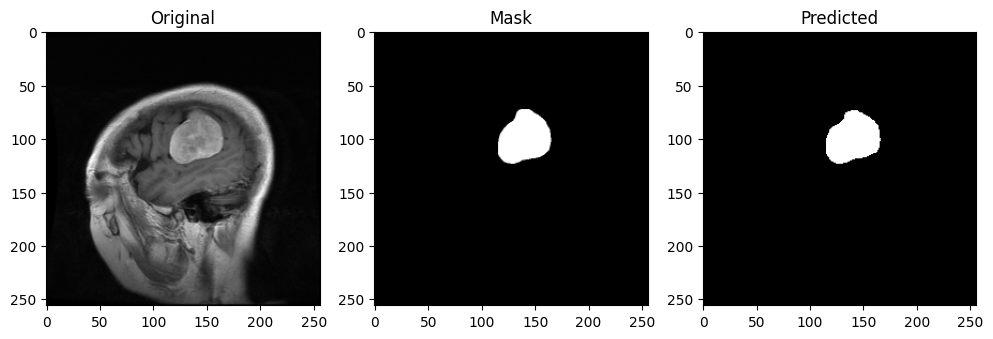

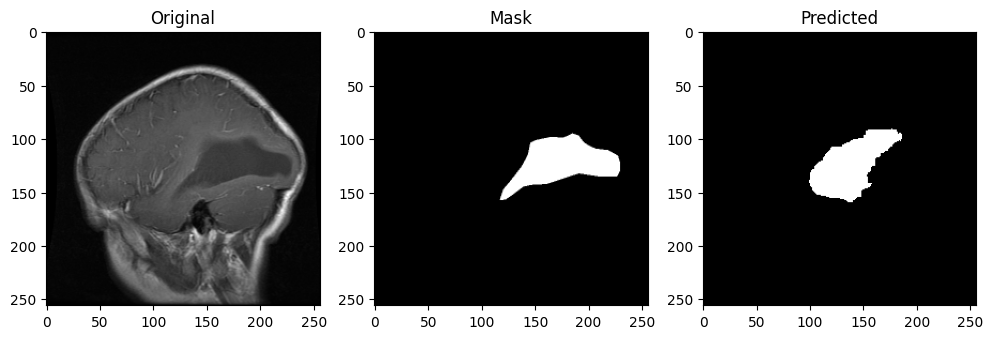

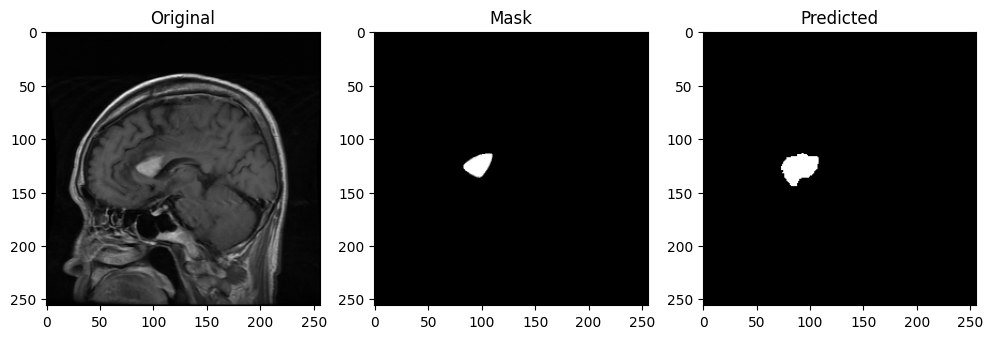

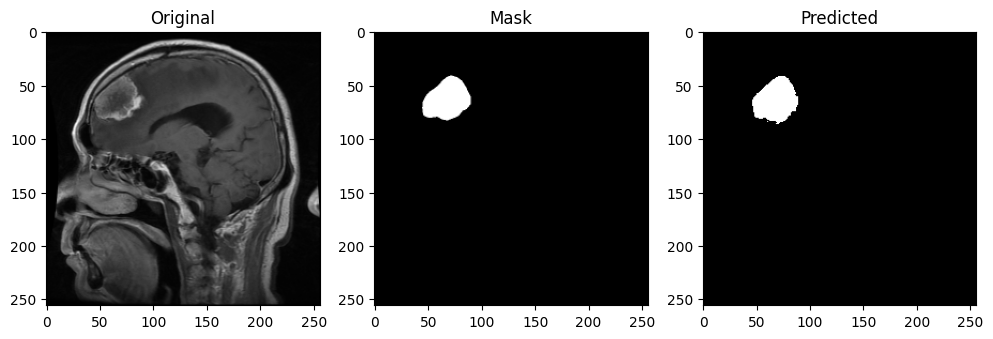

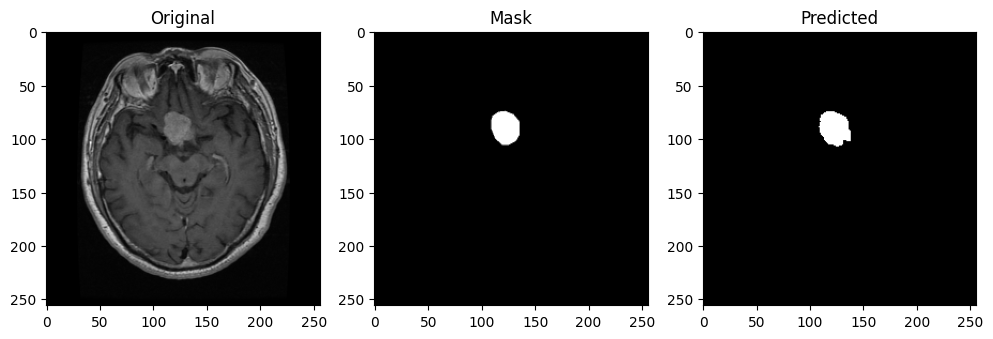

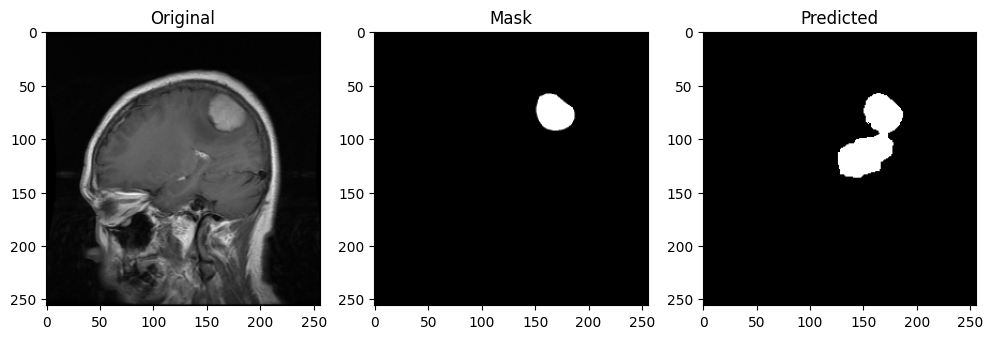

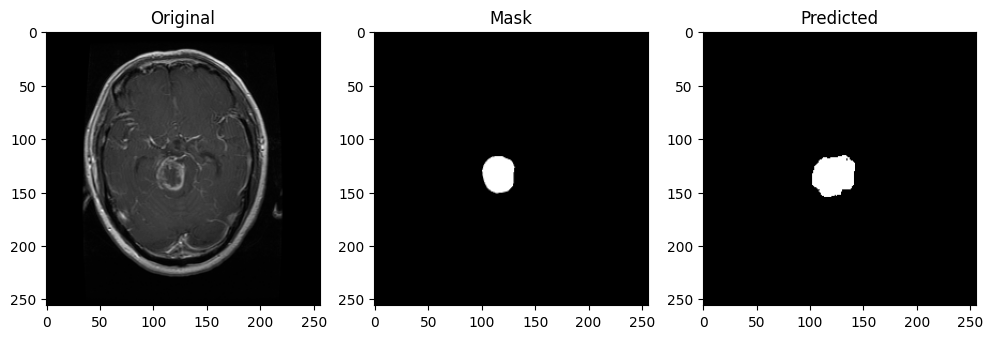

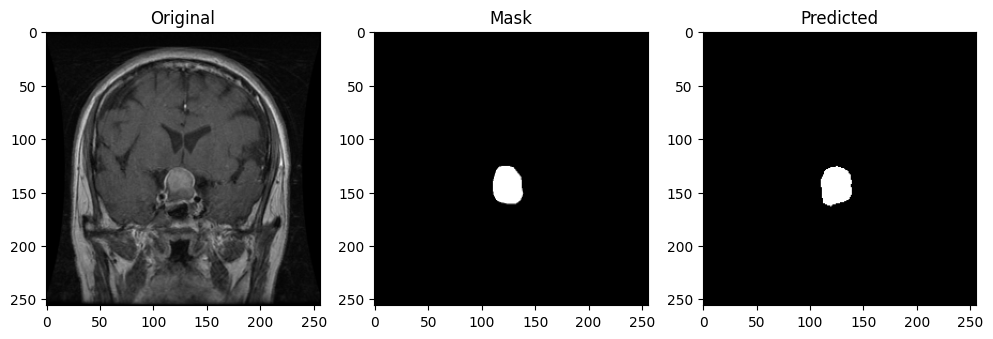

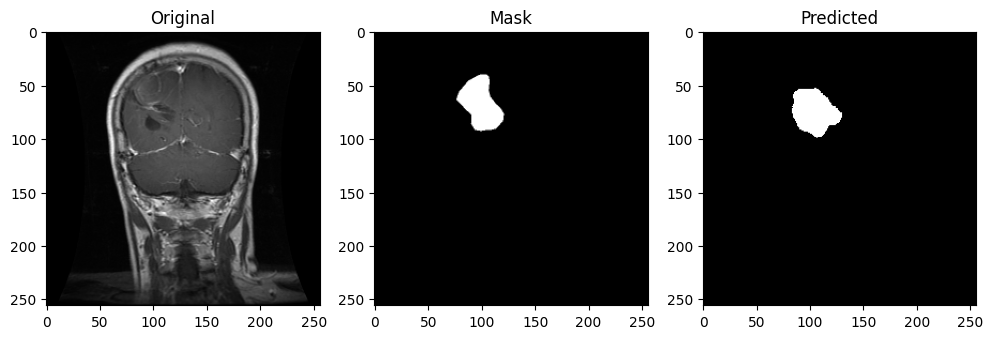

In [24]:
for i in range(10,20):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(X_test[i], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Mask')
    plt.imshow(y_test[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predicted')
    plt.imshow(y_pred[i].squeeze(), cmap='gray')

    plt.show()

In [25]:
import tensorflow as tf

y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

dice = dice_coefficient(y_test, y_pred)
iou = iou_metric(y_test, y_pred)
loss = dice_loss(y_test, y_pred)

print("Dice:", dice.numpy())
print("IoU:", iou.numpy())
print("Dice Loss:", loss.numpy())


Dice: 0.6441571
IoU: 0.4750975
Dice Loss: 0.3558429
